# Customer Segmentation Project

## Introduction

Understanding customer behavior is crucial for businesses to tailor their products and marketing strategies effectively in a competitive market. Customer segmentation is a data-driven approach to group customers based on similarities in their purchasing behavior, preferences, or demographics. 

I'm using this project to introduce myself to data science/machine learning concepts, specifically by implementing K-Means clustering to group customers based on their spending habits and annual income. By identifying distinct customer segments, businesses can develop targeted marketing strategies, improve customer satisfaction, and enhance profitability.

### Objectives:
- Analyze customer data to identify distinct segments.
- Apply K-Means clustering for unsupervised learning.
- Visualize and interpret the resulting customer segments.

I'll be using pandas for data manipulation, Matplotlib and Seaborn for visualization, and Scikit-learn to implement the K-Means algorithm.


# So what is K-Means clustering, anyway?

- K-Means clustering is an **unsupervised** machine learning algorithm used to categorize a dataset based on feature similarities.
- (Unsupervised meaning that the algo infers from data without being labeled or predefined.)
- The algo groups data into **K** clusters, K being arbitarily defined by the user. So K can be whatever you want!
- Each cluster has a **centroid**, which is just the average of all points in that cluster.

## Got it? Lets get started!

## 1. Let's first load the dataset using pandas:

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_excel('Online-Retail.xlsx')

# Inspect the first few rows
display(df.head())  # Use display() instead of print() for better formatting in Jupyter

# Check for missing values
missing_values = df.isnull().sum()
display(missing_values)  # Display the missing values


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## 2. Get that data squeaky clean!

In [2]:
# Drop rows with missing values
df.dropna(inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Convert InvoiceDate to datetime, easier to work in python this way
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Check for any negative or zero quantities
df = df[df['Quantity'] > 0]


## 3. Feature Engineering

### What's feature engineering you ask? Allow me to explain.

Feature engineering is the process of **transforming raw data** into meaningful "features" that can be used to **help machine learning models perform better**. You can create new variables ("features") or modify existing ones to capture more useful patterns and insights from the data. Effective feature engineering often leads to better model performance and can significantly improve prediction accuracy! There's alot more to it than that, but that's the gist.

#### Got it? Great!


### We are going to use RFM. Recency, Frequency, and Monetary Value

RFM is a data science model that helps businesses segment and rank customers based on their purchase behavior.
RFM analysis uses three key factors to evaluate customers:

- Recency: How **recent** a purchase was made
- Frequency: How **often** a purchase was made
- Monetary value: How **much** was spent on a product/service

In [3]:
# Create a TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Group by CustomerID to calculate Recency, Frequency, and Monetary value
snapshot_date = df['InvoiceDate'].max() + pd.DateOffset(1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'
})

# Rename columns for readability 
rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'}, inplace=True)

# View RFM table
display(rfm.head())


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


## 4. Standardizing the data...

### Quick rundown on standardization
- Standardizing our data means to transform it so that the different features each evenly contribute to the analysis of the dataset.
- The process includes making sure the data has a mean of zero and a standard deviation of one.

In [4]:
rfm['Recency'] = pd.to_numeric(rfm['Recency'], errors='coerce')
rfm['Frequency'] = pd.to_numeric(rfm['Frequency'], errors='coerce')
rfm['Monetary'] = pd.to_numeric(rfm['Monetary'], errors='coerce')

from sklearn.preprocessing import StandardScaler

# Standardize the RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


## 5. Run the K-Means algorithm
* (Note: I'm using 3 clusters, since according to the elbow plot, the optimal number is 3.)

In [20]:
from sklearn.cluster import KMeans

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=37) # The random_state is just a seed for rng (random number generator)
kmeans.fit(rfm_scaled) # This fits the KMeans algorithm to your scaled RFM data (rfm_scaled), identifying 4 groups of customers based on their RFM values.

# Add the cluster labels to the RFM dataframe
rfm['Cluster'] = kmeans.labels_

# View the first few rows with cluster labels
print(rfm.head())


            Recency  Frequency  Monetary  Cluster
CustomerID                                       
12346.0         326          1  77183.60        0
12347.0           2        182   4310.00        1
12348.0          75         31   1797.24        1
12349.0          19         73   1757.55        1
12350.0         310         17    334.40        0


## 6. And now, we visualize!!

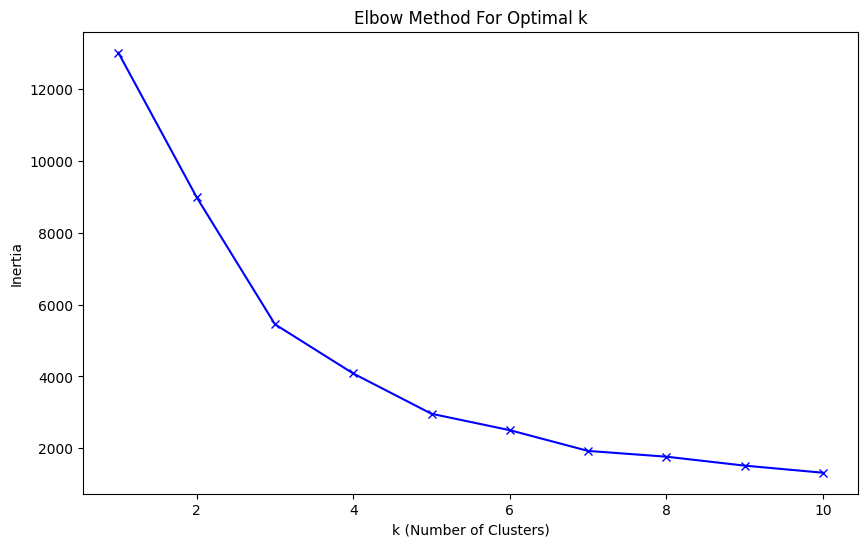

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


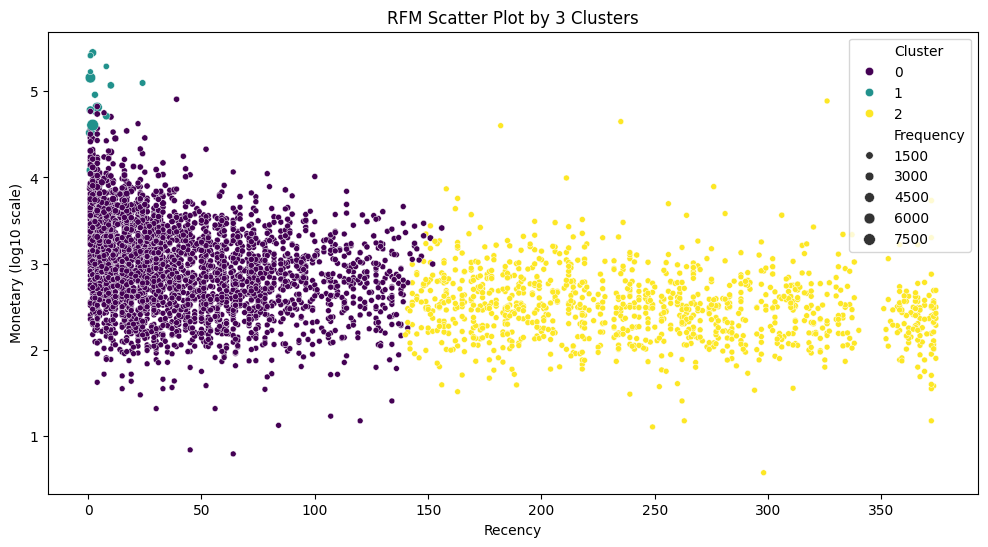

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# 1. Elbow Plot
inertias = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k (Number of Clusters)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# 2. RFM Scatter Plot with Log-transformed Monetary
# Determine the optimal number of clusters from the elbow plot
optimal_clusters = 3

# Assign cluster labels to the original RFM DataFrame
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Create the RFM scatter plot with log-transformed Monetary
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='Recency', y=np.log10(rfm['Monetary']), hue='Cluster',
    size='Frequency', data=rfm, palette='viridis'
)
plt.title(f'RFM Scatter Plot by {optimal_clusters} Clusters')
plt.xlabel('Recency')
plt.ylabel('Monetary (log10 scale)')
plt.show()